# ELEC474 Project

In [ ]:
import cv2 as cv
import numpy as np
import os
import operator
import copy
import random
import math
import time
from cv2 import Stitcher
from matplotlib import pyplot as plt

In [ ]:
global my_SIFT_instance, my_BF_instance
my_SIFT_instance = cv.SIFT_create()

FLANN_INDEX_KDTREE = 0 #heard from C++ api that this should be 1
# FLANN_INDEX_KDTREE = 1

dirName1 = 'office2'
dirName2 = 'StJames'
dirName3 = 'WLH'

imgDescipt_1 = np.array((
"Left Key Point",
"Right Key Points"
))

imgDescipt_2 = np.array((
"Select point Output",
"Epipolar Line Output"
))

WINDOW_NAME1 = "1.2 Output Image_1"
WINDOW_NAME2 = "1.2 Output Image_2"
WINDOW_NAME3 = "1.3 Input left"
WINDOW_NAME4 = "1.3 Input Right"
WINDOW_NAME5 = "1.3 output 1"
WINDOW_NAME6 = "1.3 output 2"

Process_BarLength = 30

BEST_MATCH_METRIC = 200 #StJames is 85, office2 is 200, WLH is 100
LOWE_RATIO = 0.7
SEED_IDX = 0

# Step 1

In [ ]:
class MatcheClass:
    def __init__(self, keypoint, descriptors, match):
        self.keypoints = keypoint
        self.descriptors = descriptors
        self.matchs = match
        self.img1 = []
        self.img2 = []
    
    def LoadImg1(self, img):
        self.img1 = img
    
    def LoadImg2(self, img):
        self.img2 = img
    
    def __eq__(self, other) -> bool:
        return self.__dict__ == other.__dict__
        

In [ ]:
def PltImg(img,imgDescipt):
    plt.figure(dpi=300)
    plt.figure(figsize=(15,15))
    idx = len(img)
    for i in range(idx):
        plt.subplot(1,idx,i+1)

        if(len(img[i].shape) == 2): #differ from gray and color img 
            plt.imshow(img[i],cmap="gray")
        else:
            plt.imshow(cv.cvtColor(img[i], cv.COLOR_BGR2RGB))

        plt.title(imgDescipt[i])
    plt.tight_layout()

def FetchingImgs(dirName):
    #list all the img file under dir 
    ls = []
    dir = os.getcwd()+'//'+dirName
    files = os.listdir(dir)
    for filename in files:
        # print(dir + os.sep + filename)

        if os.path.splitext(filename)[1] == '.jpg':
            ls.append(filename)
    if ls.count != 0:
        print("Detected: \n",ls)
    return ls

def ProgressionBarUpdate(current,overall):
    pctge = (current+1) / overall
    if pctge > 1:
        pctge = 1
    temp = int(round(Process_BarLength * pctge))
    print('\r%s%s%s%s'% ((temp)*'█',(Process_BarLength-temp)*'░',str(round(pctge*100)),'%'), end = ' ')


def ReadImgs(dirName, imgName):
    return cv.imread(os.getcwd()+'//'+dirName+'//'+imgName)

In [ ]:
def FindDescriptorAndKeyPoints(img,flag,descriptor = my_SIFT_instance): #if flag == 1, then do gray
    imgGray = img
    if flag == 1:
        imgGray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        
    imgKpOut = np.copy(imgGray)
    kp, des = descriptor.detectAndCompute(imgGray,None)
    # imgKpOut = cv.drawKeypoints(imgKpOut,kp,0)
    return (kp,des)

def FlannBasedMatchLoweRatio(descriptor1,descriptor2,   
                            index_param,search_param,
                            kNum, ratio):
    # img1Kp = img1Param[1]
    # img2Kp = img2Param[1]
    flann = cv.FlannBasedMatcher(index_param,search_param)
    matches = flann.knnMatch(descriptor1,descriptor2,k = kNum)

    loweMatch = []
    # loweImg1Point = []
    # loweImg2Point = []
    for m,n in matches:
        if m.distance < ratio * n.distance:
            loweMatch.append([m])
            # loweImg1Point.append(img1Kp[m.queryIdx].pt) #NOTE: append requried left and rights points  
            # loweImg2Point.append(img2Kp[m.trainIdx].pt)

    # imgOut = cv.drawMatchesKnn(img1Param[0],img1Kp,img2Param[0],img2Kp,loweMatch,None,flags=2)
    return loweMatch

In [ ]:

def Matching(ds1, ds2, loweRatio):
    #FLANN param 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)       #or pass empty dict #It specifies the number of times the trees in the index should be recursively traversed.
    # search_params = dict(checks = 100)
    Matches = FlannBasedMatchLoweRatio(ds1[1], ds2[1],
                            index_params, search_params,
                            kNum = 2, ratio = loweRatio)  #NOTE: The ratio difference of lowe will result in different epiploar lines 
    
    return MatcheClass([ds1[0],ds2[0]], [ds1[1], ds2[1]], Matches)

In [ ]:

def MatchingFeaturesOfImages(dirName, descriptorMethod):
    idx = 0
    numGoodMatch = 0
    imgList = []
    matchList = []
    descKpList = []

    # detect and extract features from the image
    if descriptorMethod == 'sift':
        descriptor = cv.xfeatures2d.SIFT_create()
    elif descriptorMethod == 'surf':
        descriptor = cv.xfeatures2d.SURF_create()
    elif descriptorMethod == 'brisk':
        descriptor = cv.BRISK_create()
    elif descriptorMethod == 'orb':
        descriptor = cv.ORB_create()
    
    print("Featching Images under Dir and creating descriptors for them")
    imgNameList = FetchingImgs(dirName)
    for imgName in imgNameList:
        idx += 1
        ProgressionBarUpdate(idx, len(imgNameList)+1)
        temp = ReadImgs(dirName, imgName)
        imgList.append(temp)
        descKpList.append(FindDescriptorAndKeyPoints(temp,flag=1, descriptor = descriptor))
        

    print("\nFind best Match for each pair of imgs")
    seedIdx = SEED_IDX
    seedImg = imgList[seedIdx]
    seedDescKp = descKpList[seedIdx]
    
    imgListIdx = list(range(len(imgList)))
    imgListIdx.remove(seedIdx)
    
    for imgIdx in imgListIdx:
        ProgressionBarUpdate(imgIdx+1,len(imgList)-1)
        
        temp = Matching(seedDescKp, descKpList[imgIdx], LOWE_RATIO)
        if len(temp.matchs) > BEST_MATCH_METRIC:
            numGoodMatch+=1
            temp.LoadImg1(seedImg)
            temp.LoadImg2(imgList[imgIdx])
            matchList.append(temp)
    
    print("\nThere are", numGoodMatch, "good Image Pairs has been find")
        
    return matchList

        

In [ ]:

m1 = MatchingFeaturesOfImages(dirName1, descriptorMethod='sift')

print("m1", m1)
# print("m2", m2)


print(len(m1))
for x in m1:
    PltImg([x.img1, x.img2],["p1","p1"])


In [ ]:

print(m1[0].keypoints[0][m1[0].matchs[0][0].queryIdx].pt)
print(m1[0].keypoints[1][m1[0].matchs[0][0].trainIdx].pt)


print(m1[-1].keypoints[0][m1[0].matchs[0][0].queryIdx].pt)
print(m1[-1].keypoints[1][m1[0].matchs[0][0].trainIdx].pt)

print(len(m1))
for i in range(len(m1)):
    print("class",i)
    test = m1[i]

    base = test.keypoints[0][0].pt

    # print(base)

    ref_pts = np.float32([test.keypoints[0][m[0].queryIdx].pt for m in test.matchs]).reshape(-1,1,2)
    img_pts = np.float32([test.keypoints[1][m[0].trainIdx].pt for m in test.matchs]).reshape(-1,1,2)

    # print(ref_pts[0])
    # print(img_pts[0])
        
    M_p, _ = cv.findHomography(img_pts, ref_pts, method = cv.RANSAC) 
    M_p_inv = np.linalg.inv(M_p)
    pt = np.pad(ref_pts[0],((0,0),(0,1)),'constant')
    # print(pt)
    test = np.dot(M_p_inv, [0,0,1])
    print(test)


# Step 2,3

In [ ]:
def DirctionAndHomoFind(M: MatcheClass):
    leftList = []
    rightList = []
    for currentMatch in M:
        
        seedImg = currentMatch.img1
        cmprImg = currentMatch.img2
        ref_kyPt = currentMatch.keypoints[0]
        img_kyPt = currentMatch.keypoints[1]
        matches = currentMatch.matchs

        ref_pts = np.float32([ref_kyPt[m[0].queryIdx].pt for m in matches]).reshape(-1,1,2)
        img_pts = np.float32([img_kyPt[m[0].trainIdx].pt for m in matches]).reshape(-1,1,2)
        
        M_p, _ = cv.findHomography(img_pts, ref_pts, method = cv.RANSAC) # invert img_pts and ref_pts to get inverse of normal M_p
        M_p_inv = np.linalg.inv(M_p)
        dirTestPt = np.dot(M_p_inv,[0,0,1])
        
        print(dirTestPt)
        if dirTestPt[0] > 0: 
            print("is Left Image")
            # PltImg([seedImg, cmprImg], ["L compare", "L source"])
            leftList.append(cmprImg)
        else:
            print("is Right Imgae")
            rightList.append(cmprImg)
            # PltImg([seedImg, cmprImg], ["R compare", "R source"])


    # imgSize = [seedImg.shape[1]+cmprImg.shape[1], seedImg.shape[0]]
    # warpImg = cv.warpPerspective(cmprImg, M_p, imgSize)
    # imgFinal = np.copy(warpImg)
    # imgFinal[0:seedImg.shape[0], 0:seedImg.shape[1]] = seedImg

    
    return seedImg, leftList, rightList
    


In [ ]:
def findHomoInSitch(img1, img2):
    img1Para = FindDescriptorAndKeyPoints(img1,flag=0)
    img2Para = FindDescriptorAndKeyPoints(img2,flag=0)
    match = Matching(img1Para, img2Para, LOWE_RATIO)
    
    img_kyPt = img2Para[0]
    ref_kyPt = img1Para[0]
    matches = match.matchs

    img_pts = np.float32([img_kyPt[m[0].trainIdx].pt for m in matches]).reshape(-1,1,2)
    ref_pts = np.float32([ref_kyPt[m[0].queryIdx].pt for m in matches]).reshape(-1,1,2)
    
    

    H, s = cv.findHomography(img_pts, ref_pts, cv.RANSAC, 4)
    
    return H

In [ ]:

def StichImgesOld(M: MatcheClass):
    
    stichLeft = []
    stichRight= []
    cmprImg = M[0].img2
    seedImg = M[0].img1
    # print(seedImg)
    isFist = True

    for mIdx in range(len((M))):
        
        if isFist:
            ref_kyPt = M[0].keypoints[0]
            img_kyPt = M[0].keypoints[1]
            matches = M[0].matchs
            isFist = False
        else:
            print("new")
            cmprImg = M[mIdx].img2
            temp = FindDescriptorAndKeyPoints(LastPerspective, flag=1)
            newMatch = Matching(temp, [M.keypoints[1], M.descriptors[1]], LOWE_RATIO)
            ref_kyPt = newMatch.keypoints[0]
            img_kyPt = newMatch.keypoints[1]
            matches = newMatch.matchs

        ref_pts = np.float32([ref_kyPt[m[0].queryIdx].pt for m in matches]).reshape(-1,1,2)
        img_pts = np.float32([img_kyPt[m[0].trainIdx].pt for m in matches]).reshape(-1,1,2)
        
        M_p, _ = cv.findHomography(img_pts, ref_pts, method = cv.RANSAC) # invert img_pts and ref_pts to get inverse of normal M_p
        M_p_inv = np.linalg.inv(M_p)
        dirTestPt = np.dot(np.linalg.inv(M_p),[0,0,1])
        
        print(dirTestPt)
        if dirTestPt[0] > 0: 
            print("is Left Image")
            stichLeft.append(StichPair(cmprImg, M_p))

        else:
            print("is Right Imgae")
            stichRight.append(StichPair(cmprImg, M_p))
            txyz = np.dot(M_p, np.array([cmprImg.shape[1], cmprImg.shape[0], 1]))
            txyz = txyz/txyz[-1]
            dsize = (int(txyz[0])+self.leftImage.shape[1], int(txyz[1])+self.leftImage.shape[0])
            tmp = cv.warpPerspective(each, H, dsize)

    # imgSize = [seedImg.shape[1]+cmprImg.shape[1], seedImg.shape[0]]
    # warpImg = cv.warpPerspective(cmprImg, M_p, imgSize)
    # imgFinal = np.copy(warpImg)
    # imgFinal[0:seedImg.shape[0], 0:seedImg.shape[1]] = seedImg

    
    return finalImage
    


In [38]:
def StichImges(seedImage, leftList, rightList):
    mainImg = seedImage
    idx = 0
    
    print("Start Combine Left Imges")
    a = leftList[0]
    for b in leftList[1:]:
        H = findHomoInSitch(a,b)
        xh = np.linalg.inv(H)

        ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1]));
        # ds = ds/ds[-1]
        f1 = np.dot(xh, np.array([0,0,1]))
        f1 = f1/f1[-1]
        xh[0][-1] += abs(f1[0])
        xh[1][-1] += abs(f1[1])
        
        offsety = abs(int(f1[1]))
        offsetx = abs(int(f1[0]))
        dsize = (int(ds[0])+offsetx, int(ds[1])+offsety)
        
        
        tmp = cv.warpPerspective(a, xh, dsize)
        tmp[offsety:b.shape[0]+offsety, offsetx:b.shape[1]+offsetx] = b
        PltImg([a,b,tmp],["source","comp","warp"])
        a = tmp
        idx += 1 
        ProgressionBarUpdate(idx, len(leftList))
    leftComb = a
    
    print("Start Combine Right Imges")
    idx = 0
    o = leftComb
    for each in rightList:
            H = findHomoInSitch(o,each)
            # print "Homography :", H
            txyz = np.dot(H, np.array([each.shape[1], each.shape[0], 1]))
            txyz = txyz/txyz[-1]
            dsize = (int(txyz[0])+o.shape[1], int(txyz[1])+o.shape[0])
            tmp = cv.warpPerspective(each, H, dsize)
            # tmp[:o.shape[0], :o.shape[1]]=o
            tmp = mix_and_match(o, tmp)
            PltImg([tmp, each, o],["result", "comp", "source"])
            o = tmp
            
            idx += 1 
            ProgressionBarUpdate(idx, len(rightList))
            

            
            
def mix_and_match(leftImage, warpedImage):
    i1y, i1x = leftImage.shape[:2]
    # i2y, i2x = warpedImage.shape[:2]


    # t = time.time()
    # black_l = np.where(leftImage == np.array([0,0,0]))
    # black_wi = np.where(warpedImage == np.array([0,0,0]))
    

    for i in range(0, i1x):
        for j in range(0, i1y):
            try:
                if(np.array_equal(leftImage[j,i],np.array([0,0,0])) and  np.array_equal(warpedImage[j,i],np.array([0,0,0]))):
                    # print "BLACK"
                    # instead of just putting it with black, 
                    # take average of all nearby values and avg it.
                    warpedImage[j,i] = [0, 0, 0]
                else:
                    if(np.array_equal(warpedImage[j,i],[0,0,0])):
                        # print "PIXEL"
                        warpedImage[j,i] = leftImage[j,i]
                    else:
                        if not np.array_equal(leftImage[j,i], [0,0,0]):
                            # bw, gw, rw = warpedImage[j,i]
                            bl,gl,rl = leftImage[j,i]
                            # b = (bl+bw)/2
                            # g = (gl+gw)/2
                            # r = (rl+rw)/2
                            warpedImage[j, i] = [bl,gl,rl]
            except:
                pass
    # cv2.imshow("waRPED mix", warpedImage)
    # cv2.waitKey()
    return warpedImage


In [ ]:
seed, lList,rList = DirctionAndHomoFind(m1)   

Start Combine Left Imges
██████████████████████████████100% Start Combine Right Imges
██████████████████████████████100% 

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-u4kjpz2z\opencv\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 9065880096 bytes in function 'cv::OutOfMemoryError'


<Figure size 1800x1200 with 0 Axes>

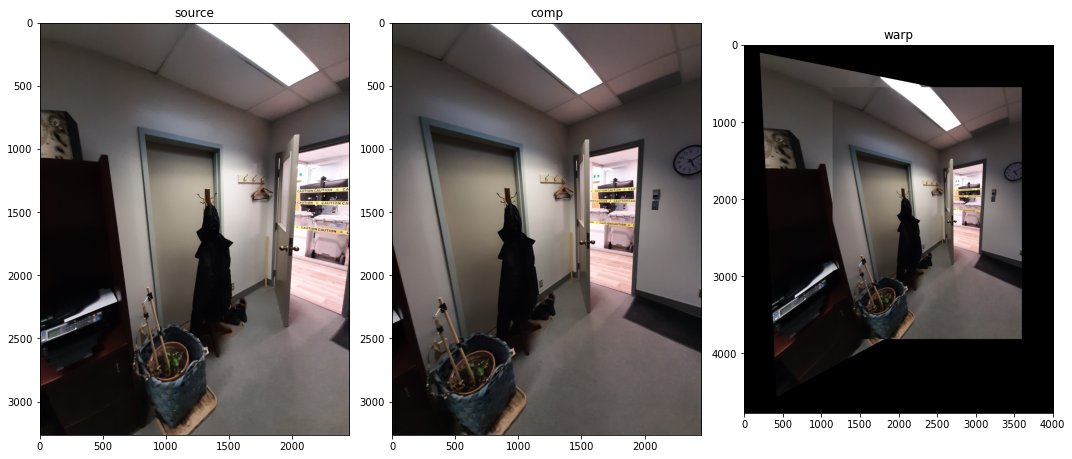

<Figure size 1800x1200 with 0 Axes>

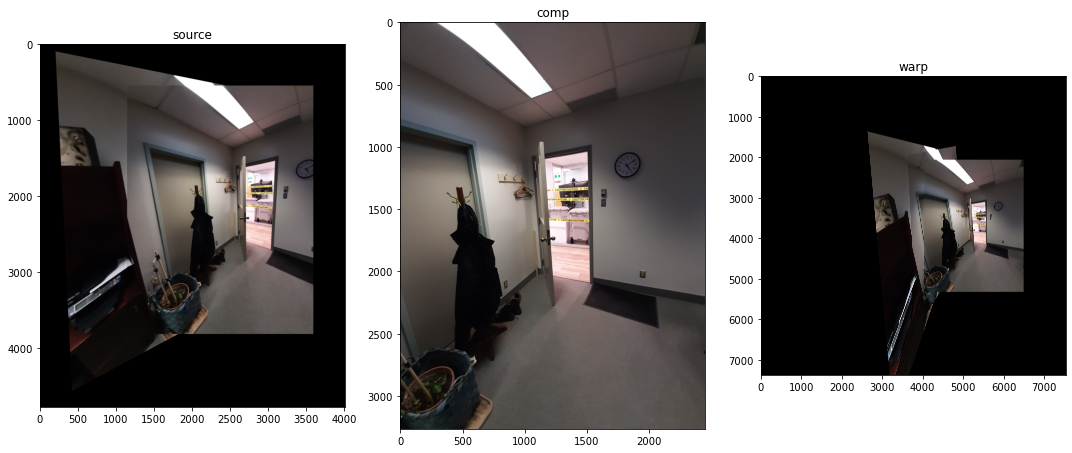

<Figure size 1800x1200 with 0 Axes>

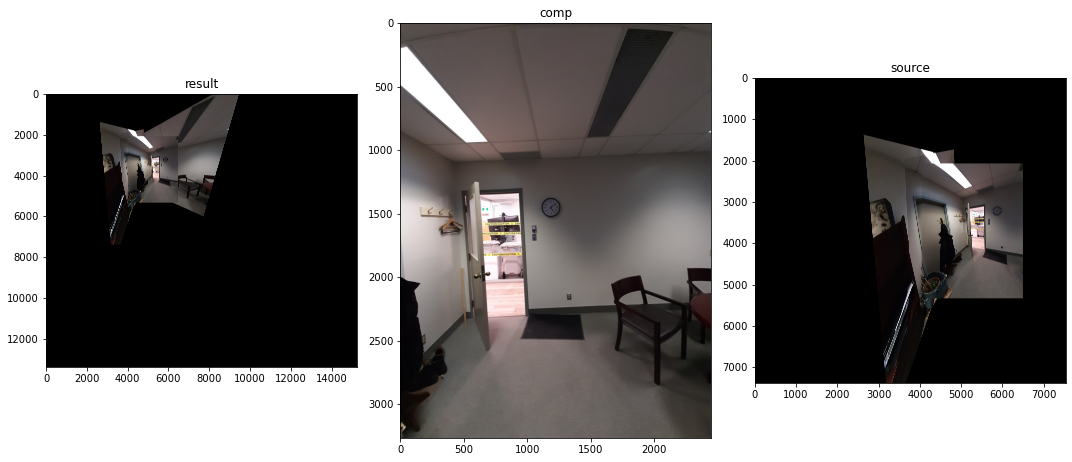

<Figure size 1800x1200 with 0 Axes>

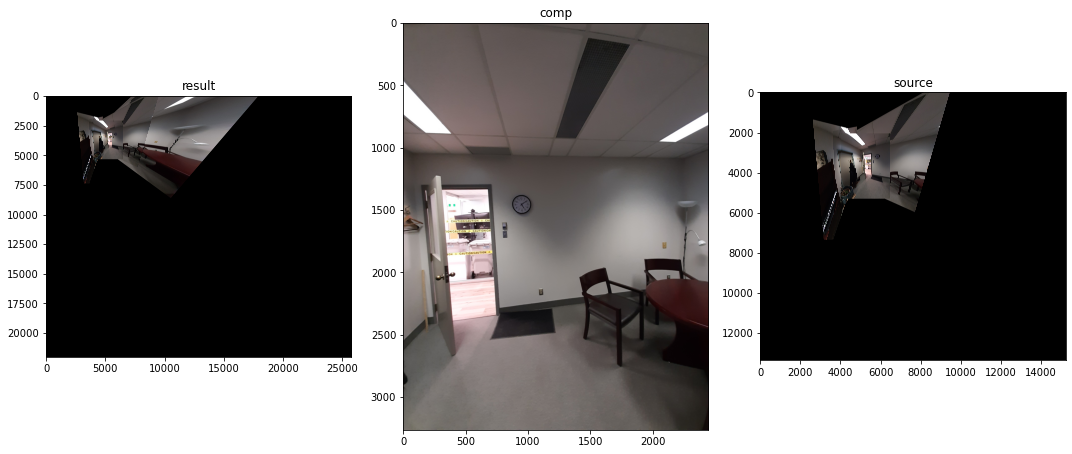

In [37]:
StichImges(seed, lList, rList)